<a href="https://colab.research.google.com/github/SJKaczmarek/lunar-astrodynamics-simulation/blob/main/lunar_orbit_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lunar Orbit Simulation with Perturbations

This notebook simulates the orbit of a satellite around the Moon, demonstrating the effect of gravitational perturbations. We start with the basic 2-body problem (Keplerian orbit) and then introduce the J2 perturbation (due to the Moon's oblateness) as a first-order correction.

**Goal:** Showcase the difference between an idealized orbit and a more realistic one influenced by the Moon's non-uniform gravity.

**Coordinate System:** Moon-Centered Inertial (MCI) frame. Origin at the Moon's center. Axes fixed relative to distant stars.

**Note:** This simulation includes the J2 perturbation. Modeling the Moon's full gravitational field, including **mascons** (mass concentrations), requires incorporating higher-order spherical harmonic coefficients (Cnm, Snm) into the acceleration calculation, which significantly increases complexity. This notebook explains the concept but implements only J2 for demonstration.

In [ ]:
# Import necessary libraries
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting

## Physical Constants for the Moon
Sources: NASA Fact Sheets, scientific literature (e.g., JPL Horizons)

In [ ]:
# Gravitational parameter (GM) of the Moon (m^3/s^2)
mu_moon = 4.9048695e12

# Mean radius of the Moon (meters)
R_moon = 1737.4e3

# J2 gravitational coefficient for the Moon (dimensionless)
# Note: Moon's J2 is much smaller than Earth's, but non-zero.
# Value varies slightly depending on the gravity model used.
J2_moon = 2.03e-4 # Approximate value

## Equations of Motion

The state vector `y` is `[x, y, z, vx, vy, vz]`.
The function `ode_moon_orbit` calculates the derivative `dy/dt = [vx, vy, vz, ax, ay, az]`.

Acceleration `a = a_central + a_j2 + a_mascons + ...`

- `a_central = -mu * r / |r|^3` (Central body, 2-body problem)
- `a_j2` depends on J2, R_moon, mu, and position (x, y, z).
- `a_mascons` would involve summing contributions from higher-order Cnm, Snm coefficients and associated Legendre polynomials - this is complex and **not implemented here**.

In [ ]:
def ode_moon_orbit(t, y, mu, R, J2):
    """
    Defines the differential equations for orbital motion around the Moon,
    including the central body gravity and the J2 perturbation.

    Args:
        t: Time (not used directly here as the EOM are time-invariant)
        y: State vector [x, y, z, vx, vy, vz]
        mu: Gravitational parameter of the central body (Moon)
        R: Equatorial radius of the central body (Moon)
        J2: J2 coefficient of the central body (Moon)

    Returns:
        dy/dt: Derivative of the state vector [vx, vy, vz, ax, ay, az]
    """
    x, y_pos, z, vx, vy, vz = y # Renamed y to y_pos to avoid conflict

    r_vec = np.array([x, y_pos, z])
    r_norm = np.linalg.norm(r_vec)
    r_sq = r_norm**2

    # --- Central Body Acceleration (2-Body) ---
    a_central = -mu / r_norm**3 * r_vec

    # --- J2 Perturbation Acceleration ---
    # Precompute factors
    pre_fac = -1.5 * mu * J2 * R**2 / r_norm**5
    z_sq_factor = 5 * (z**2 / r_sq)

    ax_j2 = pre_fac * x * (1 - z_sq_factor)
    ay_j2 = pre_fac * y_pos * (1 - z_sq_factor) # Use y_pos here
    az_j2 = pre_fac * z * (3 - z_sq_factor)

    a_j2 = np.array([ax_j2, ay_j2, az_j2])

    # --- Total Acceleration ---
    # Set J2 to 0 to simulate only the Keplerian orbit
    if J2 == 0:
        a_total = a_central
    else:
        a_total = a_central + a_j2
        # Future work: Add a_mascons here

    # --- Derivative of state vector ---
    dydt = np.zeros(6)
    dydt[0:3] = [vx, vy, vz]  # Derivatives of position are velocity
    dydt[3:6] = a_total       # Derivatives of velocity are acceleration

    return dydt

## Initial Conditions

Let's define initial conditions for a nearly circular Low Lunar Orbit (LLO), e.g., 100 km altitude.

In [ ]:
# Initial altitude (meters)
altitude = 100e3
r_initial_norm = R_moon + altitude

# Initial position (e.g., along the x-axis in the equatorial plane)
x0 = r_initial_norm
y0 = 0
z0 = 0 # Start in equatorial plane for simplicity

# Initial velocity for a circular orbit (approximate, perpendicular to position)
v_circular = np.sqrt(mu_moon / r_initial_norm)
vx0 = 0
vy0 = v_circular # Velocity along y-axis
vz0 = 0

# Initial state vector
y0_vec = np.array([x0, y0, z0, vx0, vy0, vz0])

## Simulation Setup

In [ ]:
# Simulation time span (seconds)
# Roughly 2 hours for one LLO orbit
t_orbit_approx = 2 * np.pi * np.sqrt(r_initial_norm**3 / mu_moon)
t_span = [0, 3 * t_orbit_approx] # Simulate for 3 orbits

# Time points for evaluation
t_eval = np.linspace(t_span[0], t_span[1], 1000) # 1000 points

## Run Simulations

1.  **Keplerian Orbit:** Run with J2 = 0.
2.  **Perturbed Orbit:** Run with the actual J2 value.

In [ ]:
# --- Keplerian Simulation ---
sol_kepler = solve_ivp(
    ode_moon_orbit,
    t_span,
    y0_vec,
    args=(mu_moon, R_moon, 0), # J2 = 0
    method='RK45', # Standard Runge-Kutta
    t_eval=t_eval,
    rtol=1e-8, # Relative tolerance
    atol=1e-8  # Absolute tolerance
)

# --- J2 Perturbed Simulation ---
sol_j2 = solve_ivp(
    ode_moon_orbit,
    t_span,
    y0_vec,
    args=(mu_moon, R_moon, J2_moon), # Use actual J2
    method='RK45',
    t_eval=t_eval,
    rtol=1e-8,
    atol=1e-8
)

# Check if simulations were successful
print(f"Keplerian simulation success: {sol_kepler.success}, Status: {sol_kepler.message}")
print(f"J2 Perturbed simulation success: {sol_j2.success}, Status: {sol_j2.message}")

Keplerian simulation success: True, Status: The solver successfully reached the end of the integration interval.
J2 Perturbed simulation success: True, Status: The solver successfully reached the end of the integration interval.


## Visualization

Plot the orbits in 3D and compare the Keplerian vs. J2 perturbed paths.

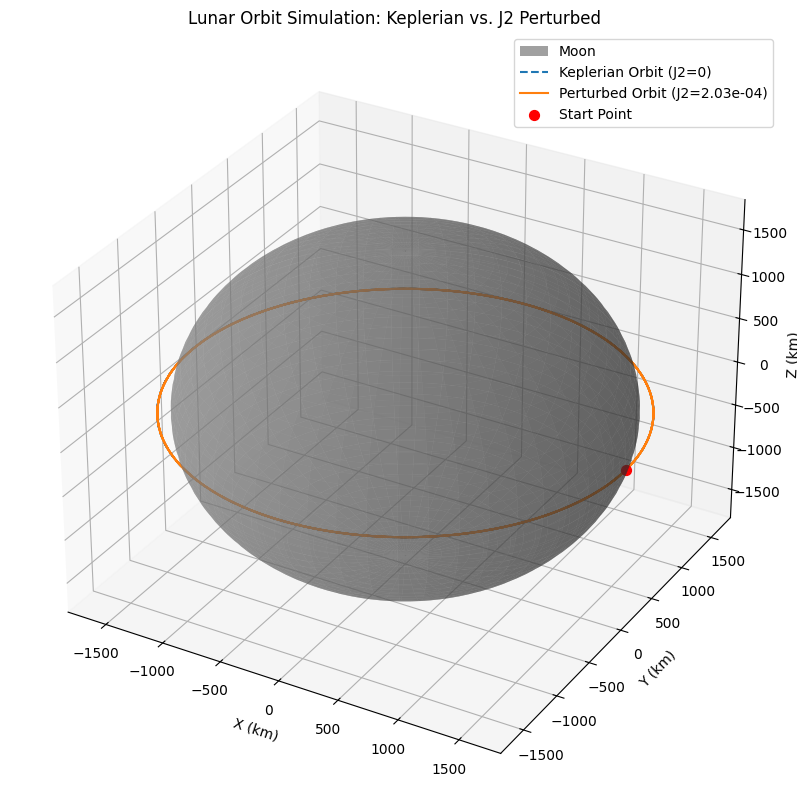

In [ ]:
# Extract position data (convert from meters to km for plotting)
x_kep = sol_kepler.y[0] / 1000
y_kep = sol_kepler.y[1] / 1000
z_kep = sol_kepler.y[2] / 1000

x_j2 = sol_j2.y[0] / 1000
y_j2 = sol_j2.y[1] / 1000
z_j2 = sol_j2.y[2] / 1000

# --- Plotting ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the Moon (approximate sphere)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
moon_x = (R_moon / 1000) * np.outer(np.cos(u), np.sin(v))
moon_y = (R_moon / 1000) * np.outer(np.sin(u), np.sin(v))
moon_z = (R_moon / 1000) * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(moon_x, moon_y, moon_z, color='grey', alpha=0.5, label='Moon') # Removed label='Moon' as plot_surface doesn't directly support it for legend

# Plot Keplerian Orbit
ax.plot(x_kep, y_kep, z_kep, label='Keplerian Orbit (J2=0)', linestyle='--')

# Plot J2 Perturbed Orbit
ax.plot(x_j2, y_j2, z_j2, label=f'Perturbed Orbit (J2={J2_moon:.2e})', linestyle='-')

# Plot start point
ax.scatter(x0/1000, y0/1000, z0/1000, color='red', s=50, label='Start Point')

# Make axes equal scale
max_range = np.array([x_j2.max()-x_j2.min(), y_j2.max()-y_j2.min(), z_j2.max()-z_j2.min()]).max() / 2.0
mid_x = (x_j2.max()+x_j2.min()) * 0.5
mid_y = (y_j2.max()+y_j2.min()) * 0.5
mid_z = (z_j2.max()+z_j2.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)


# Labels and Title
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.set_title('Lunar Orbit Simulation: Keplerian vs. J2 Perturbed')
ax.legend() # Add legend
plt.grid(True)
plt.show()

## Analysis & Discussion

The plot above compares the ideal Keplerian orbit (dashed line) with the orbit perturbed by the Moon's J2 coefficient (solid line).

**Observations:**
*   **Nodal Precession:** The J2 effect causes the orbital plane to precess (rotate) around the Moon's polar axis. This means the points where the orbit crosses the equatorial plane (nodes) shift over time. This might be subtle over only 3 orbits but is a key effect.
*   **Apsidal Precession:** The J2 effect also causes the orientation of the orbit within its plane to rotate (precession of the line of apsides - the line connecting periapsis and apoapsis).
*   **Other Effects:** J2 can also cause small periodic variations in other orbital elements.

**Importance of Mascons:** While J2 shows some effect, the Moon's gravity field is dominated by localized **mascons**. These cause much more significant and complex perturbations, especially for low lunar orbits. Accurately modeling lunar orbits for navigation, station-keeping, or landing requires gravity models incorporating many spherical harmonic terms (e.g., GRGM1200A, GLGM-3). Implementing this involves:
1.  Obtaining the Cnm, Snm coefficients for the chosen model.
2.  Implementing efficient calculations for associated Legendre polynomials (`Pnm`).
3.  Calculating the gradient of the full gravitational potential (`∇U`) to get the perturbation acceleration. This is computationally intensive.

**Limitations:** This simulation only includes J2. It ignores mascons, third-body gravity (Earth, Sun), solar radiation pressure, atmospheric drag (negligible for Moon), and potential relativistic effects.

## Conclusion & Next Steps

This notebook demonstrated the basic simulation of a lunar orbit and the initial effect of the J2 gravitational perturbation. It highlights the difference from a simple Keplerian model.

**Future Work:**
*   Implement higher-order spherical harmonic terms to model mascons accurately.
*   Add third-body perturbations (Earth, Sun).
*   Include solar radiation pressure.
*   Use more sophisticated gravity models (e.g., reading coefficients from standard files like PDS).
*   Visualize changes in orbital elements over time.